In [62]:
# =============================================================================
# OUTLIER DETECTION - Isolation Forest on Clean Match Data (ATP Main Only)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [63]:
# =============================================================================
# STEP 1: Load Matches with Player Context
# =============================================================================

# We start from the post-EDA dataset that still has player IDs/names
# so we can inspect which players/tournaments are flagged as outliers.

df = pd.read_csv('../data/processed/matches_final_with_player_context_and_no_one_hot.csv')
print(f"Shape before ATP filter: {df.shape}")

# Keep only ATP main tour matches (Qualifying_match == 0)
df = df[df['Qualifying_match'] == 0].copy()
print(f"Shape after ATP filter (ATP main only): {df.shape}")

print("\nColumns (first 15):", df.columns.tolist()[:15])
print("\nPreview:")
print(df.head())


Shape before ATP filter: (161807, 24)
Shape after ATP filter (ATP main only): (42356, 24)

Columns (first 15): ['player1_id', 'player1_name', 'player1_rank', 'player1_rank_imputed', 'player1_hand', 'player1_ht', 'player1_age', 'player1_entry', 'player2_id', 'player2_name', 'player2_rank', 'player2_rank_imputed', 'player2_hand', 'player2_ht', 'player2_age']

Preview:
   player1_id     player1_name  player1_rank  player1_rank_imputed  \
0      104053     Andy Roddick           7.0                     0   
1      104999    Mischa Zverev          78.0                     0   
2      103813  Jarkko Nieminen          88.0                     0   
3      105051    Matthew Ebden         285.0                     0   
4      105194     Nick Lindahl         251.0                     0   

  player1_hand  player1_ht  player1_age player1_entry  player2_id  \
0            R       188.0         27.3        Direct      103429   
1            L       190.0         22.3        Direct      104958   
2  

In [64]:
# =============================================================================
# STEP 2: Select Numeric Features for Isolation Forest
# =============================================================================

# We focus on "normal" per-match numeric features (no engineered history):
# - ranks, ages, heights, draw size

iso_features = [
    'player1_rank', 'player2_rank',
    'player1_age', 'player2_age',
    'player1_ht', 'player2_ht'
]

X = df[iso_features].copy()

print("Numeric features used for Isolation Forest:")
print(X.head())
print("\nMissing values per column:")
print(X.isnull().sum())

# There should be no missing after EDA; if there are any, we drop those rows
before = len(df)
mask_complete = ~X.isnull().any(axis=1)
df = df[mask_complete].copy()
X = X[mask_complete].copy()
print(f"\nDropped {before - len(df)} rows with missing numeric values. New shape: {df.shape}")


Numeric features used for Isolation Forest:
   player1_rank  player2_rank  player1_age  player2_age  player1_ht  \
0           7.0          77.0         27.3         30.3       188.0   
1          78.0         134.0         22.3         22.5       190.0   
2          88.0          52.0         28.4         23.5       185.0   
3         285.0          28.0         22.1         28.6       188.0   
4         251.0          20.0         21.4         24.2       183.0   

   player2_ht  
0       183.0  
1       198.0  
2       185.0  
3       183.0  
4       196.0  

Missing values per column:
player1_rank    0
player2_rank    0
player1_age     0
player2_age     0
player1_ht      0
player2_ht      0
dtype: int64

Dropped 0 rows with missing numeric values. New shape: (42356, 24)


In [65]:
# =============================================================================
# STEP 3: Scale Features and Fit Isolation Forest
# =============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature means after scaling (approx 0):", X_scaled.mean(axis=0))
print("Feature stds after scaling (approx 1):", X_scaled.std(axis=0))

# Use ~2% contamination as a balance between catching enough anomalies
# and not labelling too many normal matches as outliers.
iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42,
    n_jobs=-1,
)

iso_labels = iso.fit_predict(X_scaled)   # 1 = inlier, -1 = outlier
iso_scores = iso.decision_function(X_scaled)  # higher = more normal

# Store flags and scores (invert scores so higher = more anomalous)
df['iso_outlier'] = (iso_labels == -1).astype(int)
df['iso_score'] = -iso_scores

print("\nOutlier flag counts:")
print(df['iso_outlier'].value_counts())
print("\nOutlier flag proportions:")
print(df['iso_outlier'].value_counts(normalize=True))


Feature means after scaling (approx 0): [ 2.41567084e-17 -1.34203935e-17  6.81084972e-16 -2.05332021e-16
  8.08914220e-16  6.28745437e-16]
Feature stds after scaling (approx 1): [1. 1. 1. 1. 1. 1.]

Outlier flag counts:
iso_outlier
0    41932
1      424
Name: count, dtype: int64

Outlier flag proportions:
iso_outlier
0    0.98999
1    0.01001
Name: proportion, dtype: float64


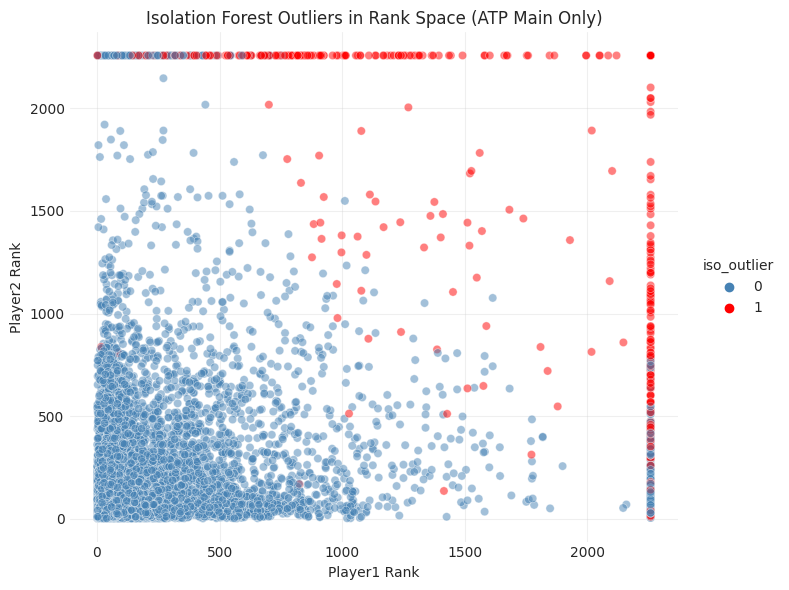

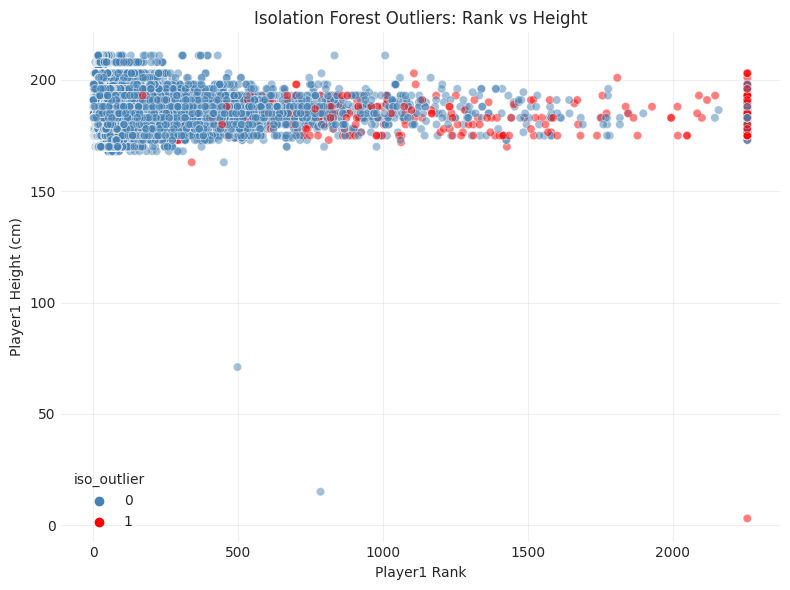

/usr/shared/CMPT/scratch/oym/459project/Tennis-Data-Prediction-/datascience-2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/shared/CMPT/scratch/oym/459project/Tennis-Data-Prediction-/datascience-2/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/shared/CMPT/scratch/oym/459project/Tennis-Data-Prediction-/datascience-2/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instea

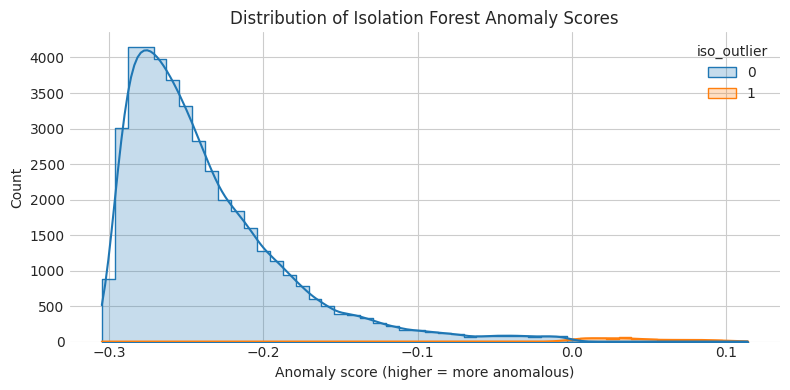

In [66]:
# =============================================================================
# STEP 4: Visualize Outliers
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 1) Player1 rank vs Player2 rank
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='player1_rank',
    y='player2_rank',
    hue='iso_outlier',
    palette={0: 'steelblue', 1: 'red'},
    alpha=0.5,
)
plt.title('Isolation Forest Outliers in Rank Space (ATP Main Only)')
plt.xlabel('Player1 Rank')
plt.ylabel('Player2 Rank')
# Move legend to the right side so it does not overlap the data
plt.legend(title='iso_outlier', loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Player1 rank vs Player1 height
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='player1_rank',
    y='player1_ht',
    hue='iso_outlier',
    palette={0: 'steelblue', 1: 'red'},
    alpha=0.5,
)
plt.title('Isolation Forest Outliers: Rank vs Height')
plt.xlabel('Player1 Rank')
plt.ylabel('Player1 Height (cm)')
plt.legend(title='iso_outlier')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Optional: anomaly score histogram
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df,
    x='iso_score',
    bins=50,
    kde=True,
    hue='iso_outlier',
    element='step',
)
plt.title('Distribution of Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly score (higher = more anomalous)')
plt.tight_layout()
plt.show()


In [67]:
# =============================================================================
# STEP 5: Inspect Top Outliers (excluding max-imputed ranks)
# =============================================================================

# We want to inspect "true" anomalies, not cases where either player has the
# max-imputed rank (2258), which we treat as structurally extreme but expected.

base_cols = [
    'player1_name', 'player2_name',
    'player1_rank', 'player2_rank',
    'player1_age', 'player2_age',
    'player1_ht', 'player2_ht',
    'player1_entry', 'player2_entry',
    'draw_size',
    'tourney_date',
    'iso_score',
]

cols_to_show = [c for c in base_cols if c in df.columns]

mask_true_outliers = (
    (df['iso_outlier'] == 1) &
    (df['player1_rank'] != 2258) &
    (df['player2_rank'] != 2258)
)

print("\nTop 20 anomalous ATP main matches (outliers with no 2258 ranks):\n")
print(
    df[mask_true_outliers]
      .sort_values('iso_score', ascending=False)[cols_to_show]
      .head(20)
      .to_string(index=False)
)



Top 20 anomalous ATP main matches (outliers with no 2258 ranks):

           player1_name         player2_name  player1_rank  player2_rank  player1_age  player2_age  player1_ht  player2_ht player1_entry player2_entry  draw_size  tourney_date  iso_score
            Roberto Cid        Nicolas Jarry        2091.0        1158.0         20.0         17.9       193.0       201.0        Direct        Direct          4      20130913   0.072788
    Christopher Eubanks        Reilly Opelka        1809.0         837.0         20.2         18.9       201.0       211.0             Q            WC         32      20160801   0.070702
   Michael Bassem Sobhy  Ainius Sabaliauskas        1561.0        1783.0         18.3         19.1       180.0       175.0        Direct        Direct          4      20220917   0.070152
  Antso Rakotondramanga     Mikelis Libietis        2018.0        1892.0         26.9         23.0       175.0       193.0        Direct        Direct          4      20150717   0.05429

## Heights less than 100 were dropped in EDA 

In [68]:
# =============================================================================
# STEP 6: Inspect Extremely Short Player1 Heights (< 100 cm)
# =============================================================================

short_mask = df['player1_ht'] < 100
cols_short = [
    'player1_name', 'player2_name',
    'player1_rank', 'player2_rank',
    'player1_age', 'player2_age',
    'player1_ht', 'player2_ht',
    'draw_size', 'tourney_date',
    'iso_outlier', 'iso_score',
]

print("\nMatches where player1_ht < 100 cm (likely data issues):\n")
print(df[short_mask][cols_short].to_string(index=False))



Matches where player1_ht < 100 cm (likely data issues):

              player1_name        player2_name  player1_rank  player2_rank  player1_age  player2_age  player1_ht  player2_ht  draw_size  tourney_date  iso_outlier  iso_score
Jorge Brian Panta Herreros Luis David Martinez        2258.0         634.0         17.6         23.8         3.0       178.0          4      20130405            1   0.061942
        Johannes Ingildsen Ramkumar Ramanathan         785.0         170.0         24.6         27.3        15.0       188.0          4      20220304            0  -0.102604
     Viacheslav Bielinskyi Christopher Eubanks         498.0          32.0         20.1         27.7        71.0       201.0          4      20240201            0  -0.057849


In [69]:
# =============================================================================
# STEP 6: Save Flagged and Filtered Datasets
# =============================================================================

# 1) With player context + outlier flags (for future analysis / feature eng)
output_flagged = '../data/processed/matches_final_with_player_context_iso.csv'
df.to_csv(output_flagged, index=False)
print(f"\n✓ Saved flagged dataset with context to: {output_flagged}")

# 2) Optional: filtered version (no outliers)
df_no_out = df[df['iso_outlier'] == 0].copy()
output_filtered = '../data/processed/matches_final_with_player_context_no_outliers.csv'
df_no_out.to_csv(output_filtered, index=False)
print(f"✓ Saved filtered dataset (no outliers) to: {output_filtered}")

print("\nRows before filtering:", len(df))
print("Rows after filtering:", len(df_no_out))



✓ Saved flagged dataset with context to: ../data/processed/matches_final_with_player_context_iso.csv
✓ Saved filtered dataset (no outliers) to: ../data/processed/matches_final_with_player_context_no_outliers.csv

Rows before filtering: 42356
Rows after filtering: 41932
